Source: https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb 

# Downloading data

In [ ]:
# see install.md to get this working
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# PyPortfolioOpt
from pypfopt import risk_models, expected_returns
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

In [ ]:
ETFs = ["SPY", "BND", "GLD", "HODL"]
ohlc = yf.download(ETFs, period="15y")  # Open, High, Low, Close
closing_prices = ohlc["Close"]
closing_prices.tail()

# Shows closing prices for the ETFs the last 5 days.


[*********************100%***********************]  4 of 4 completed


Ticker,BND,GLD,HODL,SPY
Date,,,,
2025-03-24,73.000000,277.250000,24.959999,574.080017
2025-03-25,73.089996,278.470001,24.930000,575.460022
2025-03-26,72.930000,278.239990,24.469999,568.590027
2025-03-27,72.900002,281.970001,24.629999,567.080017
2025-03-28,73.224998,283.140015,23.820000,558.820007


In [8]:
# Get closing prices, and show 5 latest ones. 
stock_prices = yf.download("SPY", period="15y")["Close"].dropna()
stock_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2010-03-29,89.153717
2010-03-30,89.214546
2010-03-31,88.910561
2010-04-01,89.518471
2010-04-05,90.248001


In [9]:
gold_prices = yf.download("GLD", period="15y")["Close"].dropna()
gold_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,GLD
Date,
2010-03-29,108.750000
2010-03-30,107.970001
2010-03-31,108.949997
2010-04-01,110.260002
2010-04-05,110.889999


In [10]:
bond_prices = yf.download("BND", period="15y")["Close"].dropna()
bond_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,BND
Date,
2010-03-29,51.427219
2010-03-30,51.531433
2010-03-31,51.576984
2010-04-01,51.560665
2010-04-05,51.260181


In [11]:
crypto_prices = yf.download("HODL", period="15y")["Close"].dropna()
crypto_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,HODL
Date,
2024-01-11,13.230
2024-01-12,12.405
2024-01-16,12.300
2024-01-17,12.145
2024-01-18,11.605


In [13]:
# Only fetches market caps for SPY and GLD

# mcaps = {}
# for t in ETFs:
#     try:
#         mcaps[t] = yf.Ticker(t).info["marketCap"]
#     except KeyError:
#         print(f"Inget market cap för {t}")
# mcaps

# Using hardcoded values instead:
mcaps = {
    "SPY": 481_714_784_600,     # manuellt från https://www.nasdaq.com/market-activity/etf/spy
    "BND": 122_936_437_056,     # manuellt från https://www.nasdaq.com/market-activity/etf/bnd
    "GLD": 77_500_318_000,      # manuellt från https://www.nasdaq.com/market-activity/etf/gld
    "HODL": 1_200_295_500        # manuellt från https://www.nasdaq.com/market-activity/etf/hodl
}
mcaps

{'SPY': 481714784600,
 'BND': 122936437056,
 'GLD': 77500318000,
 'HODL': 1200295500}

# Constructing the prior

In [18]:
# Covariance matrix between all assets
cov_matrix = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
cov_matrix

Ticker,BND,GLD,HODL,SPY
Ticker,,,,
BND,0.002955,0.002196,-0.000072,0.000031
GLD,0.002196,0.023635,0.000703,0.001152
HODL,-0.000072,0.000703,0.024429,0.002348
SPY,0.000031,0.001152,0.002348,0.028852


In [16]:
# Risk aversion
delta = black_litterman.market_implied_risk_aversion(stock_prices)
print(delta)

4.701946997604004


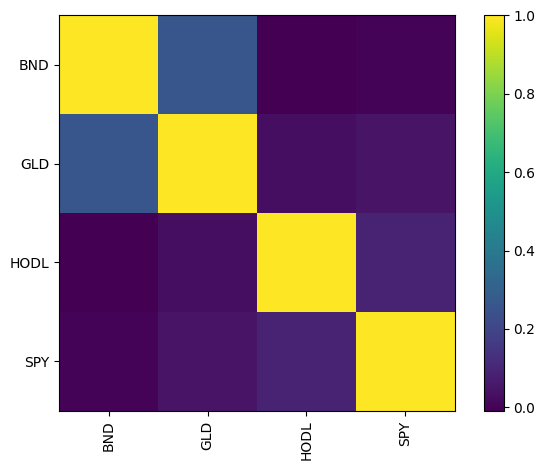

In [ ]:
plotting.plot_covariance(cov_matrix, plot_correlation=True)

In [20]:
# Prior implied returns (Pi), N×1 column vector
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)
market_prior

Ticker
BND     0.003772
GLD     0.018284
HODL    0.008300
SPY     0.096290
dtype: float64

<Axes: ylabel='Ticker'>

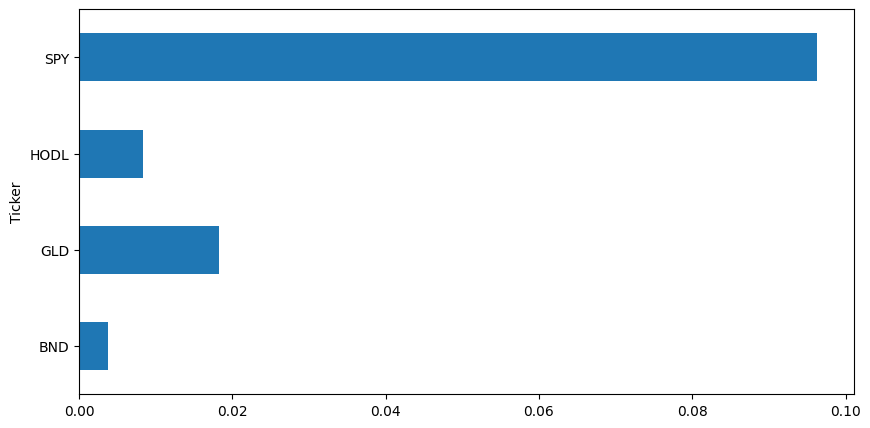

In [21]:
market_prior.plot.barh(figsize=(10,5))

# Views
Q contains the magnitude of each view, while P maps the views to the assets they belong to.

In [ ]:
# Absolute views, this should be coming from XGBoost, placeholder values atm
viewdict = {
    "SPY": 0.08,      # t.ex. +8% förväntad avkastning
    "BND": 0.03,      
    "GLD": 0.01,      
    "HODL": 0.20,
}

# View confidence
Using Idzorek's method
 - Maybe we can use some error term to evaluate the confidence levels?